Loaded 88 cycles
Epoch 1: loss=12.305315
Epoch 2: loss=10.387904
Epoch 3: loss=6.422238
Epoch 4: loss=1.184932
Epoch 5: loss=0.376512
Epoch 6: loss=0.686555
Epoch 7: loss=0.412617
Epoch 8: loss=0.179871
Epoch 9: loss=0.188828
Epoch 10: loss=0.253674
Epoch 11: loss=0.232459
Epoch 12: loss=0.174091
Epoch 13: loss=0.149501
Epoch 14: loss=0.161319
Epoch 15: loss=0.169606
Epoch 16: loss=0.160740
Epoch 17: loss=0.148080
Epoch 18: loss=0.146688
Epoch 19: loss=0.150382
Epoch 20: loss=0.149530


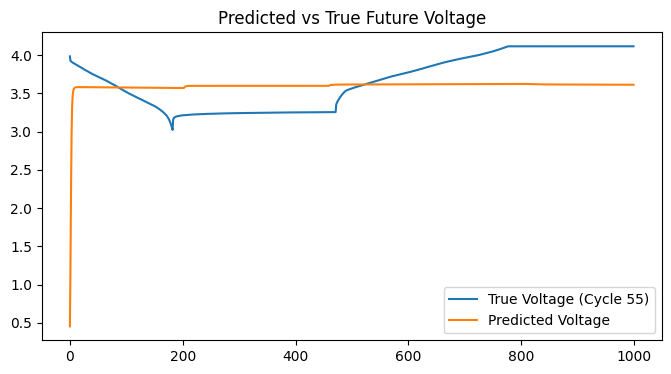

In [11]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ------------------------------
# USER CONFIG
# ------------------------------
DATA_DIR = "cycle_exports"  # folder containing per-cycle CSVs
PREDICT_OFFSET = 20                # predict voltage N cycles ahead
SEQ_LEN = 1000                        # resample each cycle to this many points
EPOCHS = 20
BATCH_SIZE = 32
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# 1️⃣ Load and resample data
# ------------------------------
def resample_cycle(df, seq_len):
    """Resample cycle to fixed seq_len points."""
    df = df.sort_values("TestTime")
    t = df["TestTime"].values
    new_t = np.linspace(t.min(), t.max(), seq_len)
    def interp(col):
        if col not in df:  # handle missing temp
            return np.zeros(seq_len)
        return np.interp(new_t, t, df[col].values)
    current = interp("Amps")
    voltage = interp("Volts")
    temp = interp("temp") if "temp" in df.columns else np.zeros(seq_len)
    return current, voltage, temp

def load_cycles(folder):
    files = sorted([f for f in os.listdir(folder) if f.endswith(".csv")])
    currents, voltages, temps = [], [], []
    for f in files:
        df = pd.read_csv(os.path.join(folder, f))
        c, v, t = resample_cycle(df, SEQ_LEN)
        currents.append(c)
        voltages.append(v)
        temps.append(t)
    return np.array(currents), np.array(voltages), np.array(temps)

currents, voltages, temps = load_cycles(DATA_DIR)
print(f"Loaded {len(currents)} cycles")

# ------------------------------
# 2️⃣ Dataset
# ------------------------------
class BatteryDataset(Dataset):
    def __init__(self, currents, voltages, temps, offset):
        self.currents = currents
        self.voltages = voltages
        self.temps = temps
        self.offset = offset
        self.n = len(currents) - offset

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # input = [current_i, voltage_i, temp_i]
        X = np.stack([self.currents[idx], self.voltages[idx], self.temps[idx]], axis=-1)
        # target = voltage of future cycle
        y = self.voltages[idx + self.offset][..., None]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

dataset = BatteryDataset(currents, voltages, temps, PREDICT_OFFSET)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# ------------------------------
# 3️⃣ LSTM Model
# ------------------------------
class BatteryLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

model = BatteryLSTM().to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ------------------------------
# 4️⃣ Training
# ------------------------------
for epoch in range(EPOCHS):
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: loss={total_loss/len(train_loader):.6f}")

# ------------------------------
# 5️⃣ Test with a random example
# ------------------------------
model.eval()
idx = np.random.randint(0, len(dataset))
with torch.no_grad():
    X, y_true = dataset[idx]
    pred = model(X.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
    true = y_true.squeeze().numpy()

plt.figure(figsize=(8,4))
plt.plot(true, label=f"True Voltage (Cycle {idx+PREDICT_OFFSET})")
plt.plot(pred, label="Predicted Voltage")
plt.title("Predicted vs True Future Voltage")
plt.legend()
plt.show()
